# Discrete analysis: Setup + test locations

This notebook serves as the setup for comparing various quantile mapping methods and parameter values for a set of locations/pixels. 

This is the setup notebook, mostly for choosing the locations/pixels. 

This analysis requires that CMIP6 data for select GCMs have been regridded to the target grid and converted to zarr stores. 

### Summarization

Once we have the results, we can create some summaries for evaluating the methods. For each variable, we will compute a set of indicators (i.e. indices) across all datasets (including ERA5 and unadjusted GCM historical and future). These indicators will be used in the following ways:

1. To compare distributions between adjusted GCM historical and the ERA5 reference data
2. To evaluate the ability of methods to preserve the changes in these indicators

In [1]:
# config cell

from pathlib import Path
import matplotlib.pyplot as plt
from pyproj import Proj
from dask.distributed import Client
import baeda

era5_dir = Path("/center1/CMIP6/kmredilla/cmip6_4km_downscaling/era5_zarr")


### Test locations

We will begin assembling our set of test locations with a set of community-based locations spread across the State. 

Here are those, mapped on a single day slice of ERA5 maximum temperature:

In [2]:
# load ERA5
client = Client()

# we are loading both precip and temp to choose some locations based on extremes in these variables
era5_stores = {
    "t2max": era5_dir.joinpath("t2max_era5.zarr"),
    "pr": era5_dir.joinpath("pr_era5.zarr"),
}

era5_ds = baeda.open_era5_dataset(era5_stores)

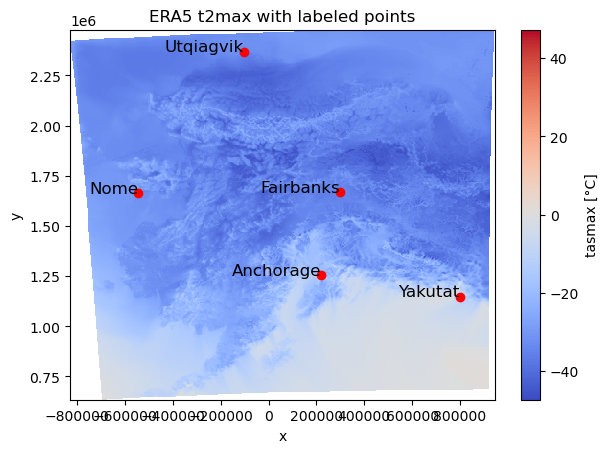

In [3]:
# project the coordinates

# Define the WKT projection for the ERA5 data
wkt_projection = era5_ds.spatial_ref.attrs["crs_wkt"]

proj = Proj(wkt_projection)

# Convert lat, lon to the projection system
projected_coords = {}
for point, latlon in baeda.coords.items():
    x, y = proj(latlon["lon"], latlon["lat"])
    projected_coords[point] = {"x": x, "y": y}

time_slice = era5_ds["tasmax"].isel(time=0).plot(cmap="coolwarm")

for point, coord in projected_coords.items():
    plt.plot(coord["x"], coord["y"], "ro")
    plt.text(coord["x"], coord["y"], point, fontsize=12, ha="right")

plt.tight_layout()
plt.title("ERA5 t2max with labeled points")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

We will also choose some pixels based on the extremeness of the location in terms of the ERA5 data:
* the coldest and warmest pixels (min and max of tasmax over timeseries)
* the average coldest and warmest (min and max of the mean of the timeseries)
* the driest and wettest, and average driest/wettest pixels, same as for the temperature extremes

In [4]:
def get_coords(da, extr_da):
    return {
        coord: da.where(da == extr_da, drop=True).squeeze()[coord].item()
        for coord in ["x", "y"]
    }


extreme_pixels = {}
tasmax_da = era5_ds["tasmax"]
tmax_da = tasmax_da.max(dim="time").load()
extreme_pixels["warmest"] = get_coords(tmax_da, tmax_da.max())
tmin_da = tasmax_da.min(dim="time").load()
extreme_pixels["coldest"] = get_coords(tmin_da, tmin_da.min())
tmean_da = tasmax_da.mean(dim="time").load()
extreme_pixels["avg_warmest"] = get_coords(tmean_da, tmean_da.max())
extreme_pixels["avg_coldest"] = get_coords(tmean_da, tmean_da.min())

prtot = era5_ds["pr"].sum(dim="time", skipna=False).load()
prtot = prtot.where(prtot != 0)
extreme_pixels["wettest"] = get_coords(prtot, prtot.max())
extreme_pixels["driest"] = get_coords(prtot, prtot.min())
prmean = era5_ds["pr"].mean(dim="time").load()
prmean = prmean.where(prmean != 0)
extreme_pixels["avg_wettest"] = get_coords(prmean, prmean.max())
extreme_pixels["avg_driest"] = get_coords(prmean, prmean.min())

# these are the coordinates of another pixel which has one of the largest negative climatological deltas for the rxnday indicators
extreme_pixels["extra_1"] = {"x": 4.839e5, "y": 1.265e6}

/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keep

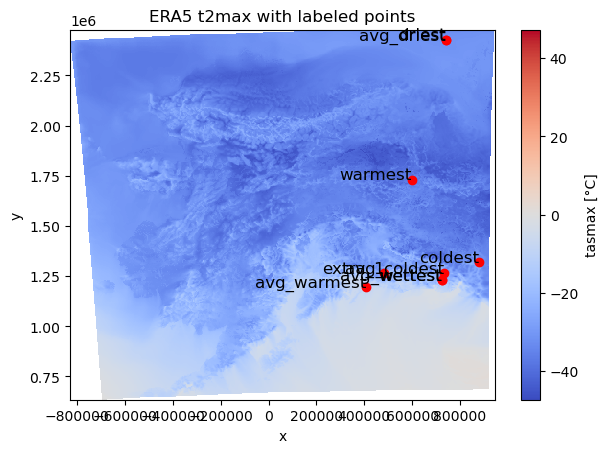

In [5]:
time_slice = era5_ds["tasmax"].isel(time=0).plot(cmap="coolwarm")

for point, coord in extreme_pixels.items():
    plt.plot(coord["x"], coord["y"], "ro")
    plt.text(coord["x"], coord["y"], point, fontsize=12, ha="right")

plt.tight_layout()
plt.title("ERA5 t2max with labeled points")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Looks like the wettest / avg wettest and driest / avg driest are the same, so we will just drop the avg_ versions of each, and instead choose two other locations in areas not yet represented: SW AK and the Brooks range. 
* SW of McGrath: 62.34197473303873, -157.0680089353049
* N of Arctic Village: 68.8372974190039, -145.63669025232795

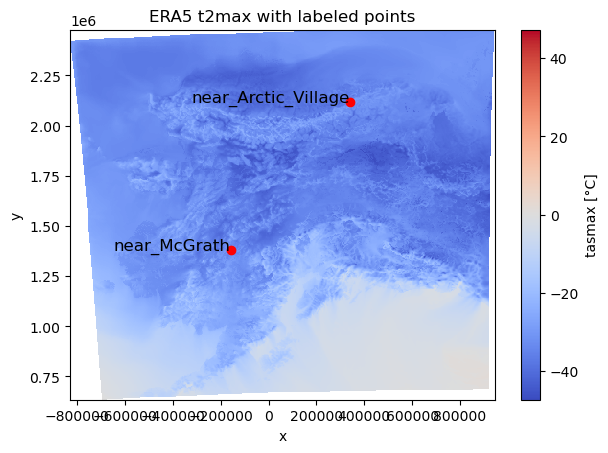

In [6]:
# drop avg_wettest and avg_driest
del extreme_pixels["avg_wettest"]
del extreme_pixels["avg_driest"]

# convert these other coordinates
other_coords = {
    "near_McGrath": {"lat": 62.34197473303873, "lon": -157.0680089353049},
    "near_Arctic_Village": {"lat": 68.8372974190039, "lon": -145.63669025232795},
}
for point, latlon in other_coords.items():
    x, y = proj(latlon["lon"], latlon["lat"])
    other_coords[point] = {"x": x, "y": y}

time_slice = era5_ds["tasmax"].isel(time=0).plot(cmap="coolwarm")

for point, coord in other_coords.items():
    plt.plot(coord["x"], coord["y"], "ro")
    plt.text(coord["x"], coord["y"], point, fontsize=12, ha="right")

plt.tight_layout()
plt.title("ERA5 t2max with labeled points")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Combine and export these coordinates as one compplete set.

In [7]:
# combine all coordinates together
coords = {
    point: {"x": coord["x"], "y": coord["y"]} for point, coord in extreme_pixels.items()
}
for point, coord in projected_coords.items():
    coords[point] = {"x": coord["x"], "y": coord["y"]}
for point, coord in other_coords.items():
    coords[point] = {"x": coord["x"], "y": coord["y"]}

coords

{'warmest': {'x': 599436.2987255983, 'y': 1730624.4491167169},
 'coldest': {'x': 880053.9955060182, 'y': 1321724.3766652476},
 'avg_warmest': {'x': 407012.7352190246, 'y': 1197450.8252339188},
 'avg_coldest': {'x': 731727.4986363677, 'y': 1265600.8373091638},
 'wettest': {'x': 723709.850156927, 'y': 1229521.419151681},
 'driest': {'x': 739745.1471158082, 'y': 2428159.8668280467},
 'extra_1': {'x': 483900.0, 'y': 1265000.0},
 'Fairbanks': {'x': 297504.537742375, 'y': 1667301.4672914068},
 'Anchorage': {'x': 219385.09124775976, 'y': 1255247.7055300924},
 'Nome': {'x': -545085.3109182257, 'y': 1662288.1529547903},
 'Yakutat': {'x': 798186.4505862442, 'y': 1147549.237487728},
 'Utqiagvik': {'x': -102347.93849425799, 'y': 2368027.8649091986},
 'near_McGrath': {'x': -158391.91330927753, 'y': 1377871.2528303924},
 'near_Arctic_Village': {'x': 340012.1339986391, 'y': 2118363.789483479}}